In [1]:
import torch

In [71]:
a = torch.stack([torch.FloatTensor([0, 2, 1]), 
                torch.FloatTensor([0, 3, 0]), 
                torch.FloatTensor([1, 2, 1]),
                torch.FloatTensor([1, 1, 0.5])], 1)
b = torch.FloatTensor([[1, 0], [0.7, 0.5], [0.1, 0.1]])

In [73]:
a

tensor([[0.0000, 0.0000, 1.0000, 1.0000],
        [2.0000, 3.0000, 2.0000, 1.0000],
        [1.0000, 0.0000, 1.0000, 0.5000]])

In [74]:
a = a.view((3, 2, 2))
a

tensor([[[0.0000, 0.0000],
         [1.0000, 1.0000]],

        [[2.0000, 3.0000],
         [2.0000, 1.0000]],

        [[1.0000, 0.0000],
         [1.0000, 0.5000]]])

In [78]:
b.shape

torch.Size([3, 2])

In [77]:
b_view = b.view(-1, 2, 1)
b_view

tensor([[[1.0000],
         [0.0000]],

        [[0.7000],
         [0.5000]],

        [[0.1000],
         [0.1000]]])

In [76]:
torch.bmm(a, b_view).view(3, 2)

tensor([[0.0000, 1.0000],
        [2.9000, 1.9000],
        [0.1000, 0.1500]])

In [64]:
#!/usr/bin/env python3
#SBATCH --cpus=1
#SBATCH --gres=gpu:1
#SBATCH --mem=20GB
#SBATCH --mail-type=ALL
#SBATCH --mail-user=abstreik
#SBATCH --time=45:00:00

In [115]:
import sys 
sys.path.append('../helper')
import pandas as pd
import torch.nn as nn
import random
from torch.optim import Adam
from torch.utils.data import DataLoader,TensorDataset
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
import RotationMatrix
import time
from sklearn.model_selection import KFold
from collections import Counter
# from tqdm import tqdm_notebook as tqdm
tqdm = lambda x: x

In [65]:
points = pd.read_csv("../data/rotated_points_angle.csv")

In [66]:
class Net(nn.Module):
    def __init__(self, n_hidden=None):
        super().__init__()
        hidden_nodes = 50 if n_hidden is None else n_hidden
        self.ff = nn.Sequential(
            nn.Linear(1, hidden_nodes),
            nn.Sigmoid(),
            nn.Linear(hidden_nodes, 1)
        )
    
    def forward(self, x_batch):
        return self.ff(x_batch)

## Check if model can learn sine function

In [67]:
def train_sin():
    random.seed(234)
    model = Net()
    opt = Adam(model.parameters())
    model.train()
    for i in tqdm(range(300000)):
        alpha = random.uniform(0, 2*math.pi)
        pred = model(torch.Tensor([alpha]))
        y_true = math.sin(alpha)
        opt.zero_grad()
        loss = (pred - y_true) ** 2
        loss.backward()
        opt.step()
    return model

In [68]:
def plot_sin_model(model):
    test = np.linspace(0, 2*math.pi, 100)
    model.eval()
    pred = model(torch.Tensor(np.matrix(test).transpose()))
    plt.plot(test, np.sin(test))
    plt.plot(test, pred.detach().numpy())
    plt.show()

In [69]:
def plot_matrix_nets(nets):
    test = np.linspace(0, 2*math.pi, 100)
    for model in nets:
        model.eval()
    fig, ax = plt.subplots(2, 2)
    ax[0, 0].plot(test, np.cos(test))
    ax[0, 0].plot(test, nets[0](torch.Tensor(np.matrix(test).transpose())).detach().numpy())
    ax[0, 1].plot(test, -np.sin(test))
    ax[0, 1].plot(test, nets[1](torch.Tensor(np.matrix(test).transpose())).detach().numpy())
    ax[1, 0].plot(test, np.sin(test))
    ax[1, 0].plot(test, nets[2](torch.Tensor(np.matrix(test).transpose())).detach().numpy())
    ax[1, 1].plot(test, np.cos(test))
    ax[1, 1].plot(test, nets[3](torch.Tensor(np.matrix(test).transpose())).detach().numpy())
    plt.show()

In [70]:
# plot_sin_model(train_sin())

# Train nets for matrix

In [71]:
def get_loader(data, shuffle=True):
    X = torch.FloatTensor(data[["x1", "y1", "alpha"]].values)
    y = torch.FloatTensor(data[["x2", "y2"]].values)
    torch_data = TensorDataset(X, y)
    loader = DataLoader(torch_data, batch_size=5, shuffle=shuffle)
    return loader

In [121]:
def l2_loss(y_pred, y_true, rotation_matrix=np.zeros((2, 2))):
    return (y_pred[0] - y_true[0]) ** 2 + (y_pred[1] - y_true[1]) ** 2

In [73]:
def calc_pred_loss(x_batch, y_batch, nets, loss_fn):
    alphas = x_batch[:, [2]]
    matrix_entries = [model(alphas) for model in nets]
    loss = 0
    preds = []
    for i in range(len(alphas)):
        predx = matrix_entries[0][i] * x_batch[i][0] + matrix_entries[1][i] * x_batch[i][1]
        predy = matrix_entries[2][i] * x_batch[i][0] + matrix_entries[3][i] * x_batch[i][1]
        loss += loss_fn((predx, predy), y_batch[i], [[matrix_entries[0][i], matrix_entries[1][i]], [matrix_entries[2][i], matrix_entries[3][i]]])
        preds.append((predx.item(), predy.item()))
    loss /= len(alphas)
    return {"loss": loss, "preds": preds}

In [74]:
def calc_loss(x_batch, y_batch, nets, loss_fn):
    return calc_pred_loss(x_batch, y_batch, nets, loss_fn)["loss"]

In [75]:
test_data = pd.read_csv("../data/test.csv")
# test_data = test_data[test_data.index % 20 == 0]
test_loader = get_loader(test_data, shuffle=False)

In [76]:
def test(net_ensemble, loss_fn=l2_loss, visualizePreds=False):
    test_preds = []
    test_true = []
    all_model_preds = []
    avg_test_loss = 0.0
    for nets in net_ensemble:
        model_preds = []
        for model in nets:
            model.eval()
        for x_batch, y_batch in test_loader:
            result = calc_pred_loss(x_batch, y_batch, nets, loss_fn)
            model_preds += result["preds"]
            avg_test_loss += result["loss"]
            test_true += list(y_batch)
        all_model_preds.append(model_preds)
        if visualizePreds:
            print("model preds:")
            plot_predictions(model_preds)
    avg_test_loss /= len(test_loader) * len(net_ensemble)
    for i in range(len(all_model_preds[0])):
        predx = 0
        predy = 0
        for model_preds in all_model_preds:
            predx += model_preds[i][0]
            predy += model_preds[i][1]
        predx /= len(all_model_preds)
        predy /= len(all_model_preds)
        test_preds.append((predx, predy))
    if visualizePreds:
        print("total preds:")
        plot_predictions(test_preds)
    test_loss = 0
    for y_pred, y_true in zip(test_preds, test_true):
        test_loss += loss_fn(y_pred, y_true, [[float('NaN'), float('NaN')], [float('NaN'), float('NaN')]])
    test_loss /= len(test_preds)
    return {"loss": test_loss.item(), "preds": test_preds}

In [162]:
def train(n_points_train_val, loss_fn, includeTests=False, prints=False, lastTrainResult=None, nEpochs=None, minEpochs=8000, hidden_nodes=None):
    torch.manual_seed(0)
    train_val_points = points.head(n_points_train_val)
    n_folds = min(n_points_train_val, 10)
    fold_indices = [(range(n_points_train_val), range(n_points_train_val))]
    if n_folds > 1:
        kf = KFold(n_folds, random_state=0)
        fold_indices = kf.split(train_val_points)

    train_loader = []
    val_loader = []
    for train_index, val_index in fold_indices:
        train_loader.append(get_loader(points.loc[train_index]))
        val_loader.append(get_loader(points.loc[val_index]))
    
    nets = [[Net(n_hidden=hidden_nodes) for _ in range(4)] for _ in range(n_folds)] if lastTrainResult is None else lastTrainResult["nets"]
    opts = []
    if lastTrainResult is None:
        for matrixnets in nets:
            optrow = []
            for model in matrixnets:
                optrow.append(Adam(model.parameters()))
            opts.append(optrow)
    else:
        opts = lastTrainResult["opts"]
    val_losses = [] if lastTrainResult is None else lastTrainResult["val_loss"]
    train_losses = [] if lastTrainResult is None else lastTrainResult["train_loss"]
    test_losses = [] if lastTrainResult is None else lastTrainResult["test_loss"]
    best_test_preds = None if lastTrainResult is None else lastTrainResult["best_test_preds"]
    epochs = [] if lastTrainResult is None else lastTrainResult["epochs"]
    epoch = 0 if lastTrainResult is None else lastTrainResult["next_epoch"]
    start_epoch = epoch
    epochs_per_validation = 500#100 if n_points_train_val > 10 else (10 if n_points_train_val > 5 else 3)
    while True:
        epoch_val_loss = 0
        epoch_train_loss = 0
        validate = (epoch % epochs_per_validation == 0)
        for fold in range(n_folds):
            # training
            for model in nets[fold]:
                model.train()
            for x_batch, y_batch in train_loader[fold]:
                loss = calc_loss(x_batch, y_batch, nets[fold], loss_fn)
                for opt in opts[fold]:
                    opt.zero_grad()
                loss.backward()
                for opt in opts[fold]:
                    opt.step()
            # validation
            if validate:
                for model in nets[fold]:
                    model.eval()
                val_loss = 0
                train_loss = 0
                for x_batch, y_batch in val_loader[fold]:
                    val_loss += calc_loss(x_batch, y_batch, nets[fold], l2_loss)
                for x_batch, y_batch in train_loader[fold]:
                    train_loss += calc_loss(x_batch, y_batch, nets[fold], loss_fn)
                val_loss /= len(val_loader[fold])
                train_loss /= len(train_loader[fold])
                epoch_val_loss += val_loss
                epoch_train_loss += train_loss

        if validate:
            epochs.append(epoch)
            epoch_val_loss /= n_folds
            epoch_train_loss /= n_folds
            val_losses.append(epoch_val_loss.item())
            train_losses.append(epoch_train_loss.item())
            if includeTests:
                test_result = test(nets, visualizePreds=False)#(epoch%1000 == 0))
                test_losses.append(test_result["loss"])
                if len(val_losses) > 1 and (best_test_preds is None or val_losses[-1] < min(val_losses[1:-1])):
                    best_test_preds = test_result["preds"]
        if prints and epoch % 500 == 0:
            print("Epoch {}:\tTrain {}\tVal {}\tTest {}".format(epoch, train_losses[-1], val_losses[-1], test_losses[-1]))
        epoch += 1
        reference_loss_index = 1000 // epochs_per_validation
        if (nEpochs is None and epoch > max(n_points_train_val * 200, minEpochs) and val_losses[-1] >= val_losses[-reference_loss_index]) or (nEpochs is not None and epoch - start_epoch >= nEpochs):
            break
    
    return {"nets": nets, 
            "opts": opts,
            "train_loss": train_losses, 
            "val_loss": val_losses, 
            "test_loss": test_losses, 
            "best_test_preds": best_test_preds,
            "epochs": epochs,
            "next_epoch": epoch
           }

In [156]:
def visualize_train(train_results, keys=["train_loss", "val_loss", "test_loss"]):
    for i, train_result in enumerate(train_results):
        for key in keys:
            plt.plot(train_result["epochs"], train_result[key], label='{}_{}'.format(key, i))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()

In [79]:
def plot_predictions(preds):
    plt.figure()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.ylim(-1.2, 1.2)
    plt.xlim(-1.2, 1.2)
    for i, pred in enumerate(preds):
        test_point = test_data.iloc[i]
        plt.plot([test_point["x1"], test_point["x2"]], [test_point["y1"], test_point["y2"]], color="green", linewidth=0.5)
        plt.plot([pred[0], test_point["x2"]], [pred[1], test_point["y2"]], color="red", linewidth=0.5)

    plt.show()

In [178]:
def plot_angle_loss(pred_list):
    plt.figure()
    for preds in pred_list:
        angle_losses = Counter()
        angle_n = Counter()
        for i, pred in enumerate(preds):
            angle = test_data.iloc[i]["alpha"]
            angle_losses[angle] += l2_loss(pred, test_data.iloc[0][["x1", "y1"]].values, np.zeros((2,2)))
            angle_n[angle] += 1
        x = []
        y = []
        for angle, loss in sorted(angle_losses.items()):
            x.append(angle)
            y.append(loss / angle_n[angle])
        plt.plot(x, y)
    plt.xlabel("alpha")
    plt.ylabel("avg loss")
    plt.ylim(ymin=0)
    plt.show()

## Train with n points until convergence using l2_loss

### Compare different numbers of hidden nodes

In [80]:
n_points_train_val = 10

In [81]:
def try_different_hidden_nodes():
    results_hidden_nodes = []
    for n_hidden in [5, 10, 20, 50, 100]:
        print("Start calculation for {} hidden nodes.".format(n_hidden))
        nEpochs = 30000 if n_hidden < 50 else 70000
        train_result = train(n_points_train_val, l2_loss, includeTests=True, prints=True, nEpochs=nEpochs, hidden_nodes=n_hidden)
        del train_result["nets"]
        del train_result["opts"]
        results_hidden_nodes.append([n_hidden, str(train_result)])
    results_hidden_nodes = pd.DataFrame(results_hidden_nodes, columns=["n_hidden", "train_result"])
    results_hidden_nodes.to_csv("results_hidden_nodes.csv", index=False)

In [82]:
# try_different_hidden_nodes()

In [83]:
results_hidden_nodes = pd.read_csv("results_hidden_nodes.csv")
results_hidden_nodes["train_result"] = results_hidden_nodes.apply(lambda row: eval(row["train_result"]), axis=1)

In [84]:
# visualize_train(results_hidden_nodes["train_result"], keys=["val_loss"])

Result: Choose 50 hidden nodes (tradeoff between minimum validation loss and epochs to reach it)
Difficulty: Validation loss with few data is unreliable

### Calculate for different numbers of points and save results

In [85]:
def try_different_n_data():
    results_limited_data = []
    for n_points_train_val in range(1, 36):
        print("Start calculation for {} points.".format(n_points_train_val))
        train_result = train(n_points_train_val, l2_loss, includeTests=True, prints=True, minEpochs=12000)
        del train_result["nets"]
        del train_result["opts"]
        results_limited_data.append([n_points_train_val, str(train_result)])
        if n_points_train_val >= 20 and n_points_train_val % 5 == 0:
            df = pd.DataFrame(results_limited_data, columns=["n_points_train_val", "train_result"])
            df.to_csv("train_limited_data_results_{}.csv".format(n_points_train_val), index=False)
    results_limited_data = pd.DataFrame(results_limited_data, columns=["n_points_train_val", "train_result"])
    results_limited_data.to_csv("results_limited_data.csv", index=False)

In [86]:
# try_different_n_data()

In [87]:
results_limited_data = pd.read_csv("train_limited_data_results_35.csv", index_col="n_points_train_val")
results_limited_data["train_result"] = results_limited_data.apply(lambda row: eval(row["train_result"]), axis=1)

In [88]:
# plt.plot(results_limited_data.index, results_limited_data.apply(lambda x: min(x["train_result"]["test_loss"]), axis=1))
# plt.show()

In [89]:
# plt.plot(results_limited_data.index, results_limited_data.apply(lambda x: min(x["train_result"]["val_loss"]), axis=1))
# plt.show()

Result: For at least the first 11 data points, the rotation is approximated well, validation loss again does not reflect test

## Add different loss functions

In [90]:
# Choose a specific number of points to further experiment with
n_points_train_val = 10
train_result = results_limited_data["train_result"][n_points_train_val]

In [91]:
def norm_loss(y_pred, y_true, rotation_matrix):
    return (l2_loss(y_pred, (0,0), np.zeros((2,2))) - 1) ** 2

In [92]:
def det_loss(y_pred, y_true, rotation_matrix):
    det = rotation_matrix[0][0] * rotation_matrix[1][1] - rotation_matrix[0][1] * rotation_matrix[1][0]
    return (det - 1) ** 2

In [93]:
# first weight is for l2_loss, second weight for det_loss, third for norm loss
def get_mixed_lossfn(weigths):
    def mixed_loss(y_pred, y_true, rotation_matrix):
        l0 = l2_loss(y_pred, y_true, rotation_matrix)
        l1 = det_loss(y_pred, y_true, rotation_matrix)
        l2 = norm_loss(y_pred, y_true, rotation_matrix)
        return weigths[0] * l0 + weigths[1] * l1 + weigths[2] * l2
    return mixed_loss

In [94]:
def try_different_det_loss():
    results_det_loss = []
    for det_loss_weight in [0.4, 1, 2, 3, 4]:
        weights = (1, det_loss_weight, 0)
        print("Start calculation for weights = {}.".format(weights))
        train_result_tmp = train(n_points_train_val, get_mixed_lossfn(weights), includeTests=True, prints=True, nEpochs=40000)
        del train_result_tmp["nets"]
        del train_result_tmp["opts"]
        results_det_loss.append([weights, str(train_result_tmp)])
    results_det_loss = pd.DataFrame(results_det_loss, columns=["loss_weights", "train_result"])
    results_det_loss.to_csv("results_det_loss.csv", index=False)

In [95]:
# try_different_det_loss()

In [105]:
results_det_loss = pd.read_csv("results_det_loss.csv")
results_det_loss["train_result"] = results_det_loss.apply(lambda row: eval(row["train_result"]), axis=1)

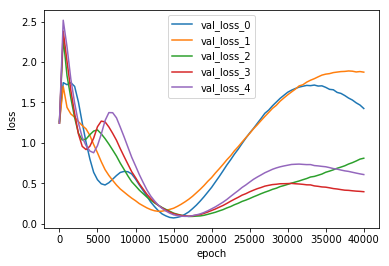

In [108]:
visualize_train(results_det_loss["train_result"], keys=["val_loss"])

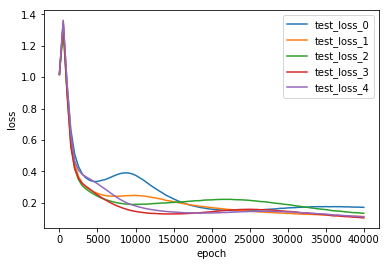

In [147]:
visualize_train(results_det_loss["train_result"], keys=["test_loss"])

Result: take det_loss_weight = 3

In [98]:
def try_different_norm_loss():
    results_norm_loss = []
    for norm_loss_weight in [0, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 1.5, 2, 2.5]:
        weights = (1, 0, norm_loss_weight)
        print("Start calculation for weights = {}.".format(weights))
        train_result_tmp = train(n_points_train_val, get_mixed_lossfn(weights), includeTests=True, prints=True, nEpochs=40000)
        del train_result_tmp["nets"]
        del train_result_tmp["opts"]
        results_norm_loss.append([weights, str(train_result_tmp)])
    results_norm_loss = pd.DataFrame(results_norm_loss, columns=["loss_weights", "train_result"])
    results_norm_loss.to_csv("results_norm_loss.csv", index=False)

In [99]:
# try_different_norm_loss()

In [100]:
results_norm_loss = pd.read_csv("results_norm_loss.csv")
results_norm_loss["train_result"] = results_norm_loss.apply(lambda row: eval(row["train_result"]), axis=1)

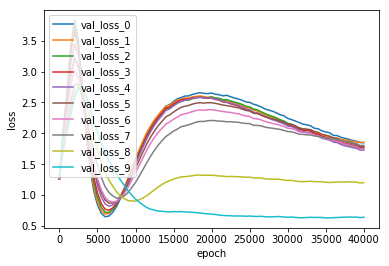

In [145]:
visualize_train(results_norm_loss["train_result"], keys=["val_loss"])

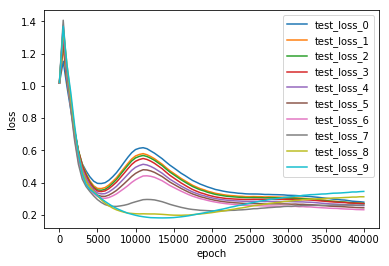

In [146]:
visualize_train(results_norm_loss["train_result"], keys=["test_loss"])

Results: choose norm_loss_weight = 2.5

In [109]:
train_result_mixed = train(n_points_train_val, get_mixed_lossfn((1, 3, 2.5)), includeTests=True, prints=True, nEpochs=40000)

Epoch 0:	Train 4.849813938140869	Val 1.3078393936157227	Test 1.0224689245224
Epoch 500:	Train 0.7054673433303833	Val 1.4856330156326294	Test 1.3065646886825562
Epoch 1000:	Train 0.5089650750160217	Val 1.1152077913284302	Test 1.0354833602905273
Epoch 1500:	Train 0.35065069794654846	Val 0.9525381922721863	Test 0.6780644059181213
Epoch 2000:	Train 0.24107274413108826	Val 0.7876813411712646	Test 0.48409131169319153
Epoch 2500:	Train 0.19550512731075287	Val 0.6729069948196411	Test 0.40759825706481934
Epoch 3000:	Train 0.1643316000699997	Val 0.5905386209487915	Test 0.3703157603740692
Epoch 3500:	Train 0.15129603445529938	Val 0.5321643948554993	Test 0.35153698921203613
Epoch 4000:	Train 0.13762326538562775	Val 0.46147602796554565	Test 0.33853399753570557
Epoch 4500:	Train 0.12515607476234436	Val 0.429901123046875	Test 0.327188104391098
Epoch 5000:	Train 0.11470203101634979	Val 0.4584861695766449	Test 0.3168554902076721
Epoch 5500:	Train 0.10127316415309906	Val 0.5367750525474548	Test 0.305654

In [112]:
train_result_mixed2 = train(n_points_train_val, get_mixed_lossfn((1, 3, 2.5)), includeTests=True, prints=True, nEpochs=40000, lastTrainResult=train_result_mixed)

Epoch 40500:	Train 0.003639275673776865	Val 1.285701036453247	Test 0.08812223374843597
Epoch 41000:	Train 0.0035002194344997406	Val 1.2874852418899536	Test 0.0869971513748169
Epoch 41500:	Train 0.0037098336033523083	Val 1.2884715795516968	Test 0.08675938844680786
Epoch 42000:	Train 0.003521465230733156	Val 1.2899118661880493	Test 0.0853148102760315
Epoch 42500:	Train 0.0033821898978203535	Val 1.2931246757507324	Test 0.0854015201330185
Epoch 43000:	Train 0.002968371380120516	Val 1.2840977907180786	Test 0.08411461114883423
Epoch 43500:	Train 0.002939449157565832	Val 1.2903687953948975	Test 0.08334602415561676
Epoch 44000:	Train 0.0029288274236023426	Val 1.2884496450424194	Test 0.08284968137741089
Epoch 44500:	Train 0.002875968813896179	Val 1.2900490760803223	Test 0.08226153254508972
Epoch 45000:	Train 0.0027195229195058346	Val 1.288280963897705	Test 0.08162155747413635
Epoch 45500:	Train 0.0028020599856972694	Val 1.2896132469177246	Test 0.0808899998664856
Epoch 46000:	Train 0.00277681602

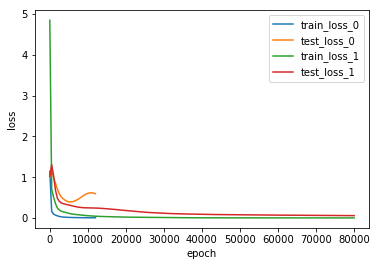

In [182]:
visualize_train([train_result, train_result_mixed2], keys=["train_loss", "test_loss"])

In [184]:
train_result_mixed2["train_loss"][10000]

IndexError: list index out of range

In [181]:
points.head(11)

,alpha,x1,y1,x2,y2
0,5.438695,-0.545621,0.838032,0.264186,0.964472
1,5.801473,0.627280,-0.778793,0.195085,-0.980786
2,3.019100,-0.999402,-0.034592,0.996140,-0.087781
3,5.976845,0.828136,-0.560527,0.620542,-0.784173
4,2.178330,0.979987,-0.199063,-0.395977,0.918260
5,5.518182,-0.998790,0.049179,-0.686449,0.727178
6,2.449045,-0.093769,0.995594,-0.563521,-0.826102
7,2.442625,-0.399496,-0.916735,0.895669,0.444720
8,1.746875,-0.764734,0.644346,-0.500424,-0.865780
9,0.113374,-0.213036,0.977044,-0.322202,0.946671


Results: 
(1, 2, 0.2) is better, converges to 0.18 test loss
(1, 2, 8) is worse
(1, 4, 0.2) really bad

Loss:
4.435518931515711
Loss:
3.5805726746598645
Loss:
2.876560454138944
Loss:
2.4571347733955475
Loss:
2.4354360446586947
Loss:
2.792530362929176
Loss:
3.3160330382733214
Loss:
3.6933004635809095
Loss:
3.6994939758323304
Loss:
3.3045336666414067
Loss:
2.6351650158995787
Loss:
1.8743006677136202
Loss:
1.1841524915314239
Loss:
0.6750564762622215
Loss:
0.4046570765334869
Loss:
0.3892325599659712
Loss:
0.6169014211848907
Loss:
6.501393162637173
Loss:
5.043629779458632
Loss:
3.987160090520346
Loss:
3.4180677259126684
Loss:
3.306010848207105
Loss:
3.537696663518656
Loss:
3.8473410486242807
Loss:
3.936811409868562
Loss:
3.6498477178667605
Loss:
3.024214319863886
Loss:
2.218067476556062
Loss:
1.4100856610452828
Loss:
0.7391815231102784
Loss:
0.2880136523655392
Loss:
0.09017835511431786
Loss:
0.14435007948436077
Loss:
0.4275079521693971
Loss:
6.953480713134324
Loss:
5.506633032363881
Loss:
4.704745758074719
Loss:
4.312051891503985
Loss:
4.149850532728411
Loss:
4.13587336573786
Loss:
4.07107777

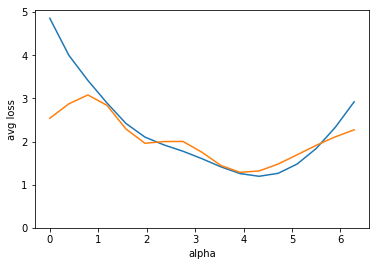

In [179]:
plot_angle_loss([train_result["best_test_preds"], train_result_mixed["best_test_preds"]])

### Dynamically change loss function

In [173]:
train_result_dyn = None

In [174]:
for _ in range(2000):
    train_result_dyn = train(n_points_train_val, get_mixed_lossfn((1, 0, 0)), includeTests=True, prints=True, nEpochs=2, lastTrainResult=train_result_dyn)
    train_result_dyn = train(n_points_train_val, get_mixed_lossfn((0, 3, 0)), includeTests=True, prints=True, nEpochs=1, lastTrainResult=train_result_dyn)
    train_result_dyn = train(n_points_train_val, get_mixed_lossfn((1, 0, 0)), includeTests=True, prints=True, nEpochs=2, lastTrainResult=train_result_dyn)
    train_result_dyn = train(n_points_train_val, get_mixed_lossfn((0, 0, 2.5)), includeTests=True, prints=True, nEpochs=1, lastTrainResult=train_result_dyn)

Epoch 0:	Train 1.1443212032318115	Val 1.2612437009811401	Test 1.0158511400222778
Epoch 500:	Train 0.40383148193359375	Val 2.1748714447021484	Test 1.3471518754959106
Epoch 1000:	Train 0.2087535858154297	Val 1.5299546718597412	Test 1.3758025169372559
Epoch 1500:	Train 0.15696388483047485	Val 1.346747636795044	Test 1.2160518169403076
Epoch 2000:	Train 0.30681711435317993	Val 1.2444591522216797	Test 1.0789216756820679
Epoch 2500:	Train 0.11215783655643463	Val 1.145076036453247	Test 0.9401760101318359
Epoch 3000:	Train 0.08937621116638184	Val 1.0415877103805542	Test 0.8062804341316223
Epoch 3500:	Train 0.18664947152137756	Val 0.9504297375679016	Test 0.6889654994010925
Epoch 4000:	Train 0.059655822813510895	Val 0.8748468160629272	Test 0.604068398475647
Epoch 4500:	Train 0.0497068390250206	Val 0.8177509307861328	Test 0.5453460812568665
Epoch 5000:	Train 0.1245446652173996	Val 0.7881062626838684	Test 0.5052423477172852
Epoch 5500:	Train 0.03567405790090561	Val 0.7726678252220154	Test 0.4795954

In [175]:
for _ in range(2000):
    train_result_dyn = train(n_points_train_val, get_mixed_lossfn((1, 0, 0)), includeTests=True, prints=True, nEpochs=2, lastTrainResult=train_result_dyn)
    train_result_dyn = train(n_points_train_val, get_mixed_lossfn((0, 3, 0)), includeTests=True, prints=True, nEpochs=1, lastTrainResult=train_result_dyn)
    train_result_dyn = train(n_points_train_val, get_mixed_lossfn((1, 0, 0)), includeTests=True, prints=True, nEpochs=2, lastTrainResult=train_result_dyn)
    train_result_dyn = train(n_points_train_val, get_mixed_lossfn((0, 0, 2.5)), includeTests=True, prints=True, nEpochs=1, lastTrainResult=train_result_dyn)

Epoch 12000:	Train 0.013324437662959099	Val 0.6558581590652466	Test 0.33491379022598267
Epoch 12500:	Train 0.0661543682217598	Val 0.6533068418502808	Test 0.32914671301841736
Epoch 13000:	Train 0.013162476010620594	Val 0.6219835877418518	Test 0.3255510628223419
Epoch 13500:	Train 0.012039553374052048	Val 0.6042834520339966	Test 0.32390955090522766
Epoch 14000:	Train 0.06124453619122505	Val 0.5928980112075806	Test 0.3186783790588379
Epoch 14500:	Train 0.012369588017463684	Val 0.5579423904418945	Test 0.31672951579093933
Epoch 15000:	Train 0.011291955597698689	Val 0.5346633195877075	Test 0.3122556209564209
Epoch 15500:	Train 0.05629798024892807	Val 0.5201835036277771	Test 0.30762332677841187
Epoch 16000:	Train 0.01170923188328743	Val 0.48231983184814453	Test 0.3054868280887604
Epoch 16500:	Train 0.01076518278568983	Val 0.4600006937980652	Test 0.30117958784103394
Epoch 17000:	Train 0.052434541285037994	Val 0.4460541307926178	Test 0.2981145679950714
Epoch 17500:	Train 0.011012367904186249	Va